In [7]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [8]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [9]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(project='UCUC0006')
cluster.scale(32)
cluster

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40301 instead
  http_address["port"], self.http_server.port


In [10]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.27:36673 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/40301/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load Data

In [11]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [12]:
%%time
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_ctrl_mean

CPU times: user 654 ms, sys: 71.4 ms, total: 726 ms
Wall time: 8.55 s


<xarray.Dataset>
Dimensions:   (nlat: 93, nlon: 320)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    length    float64 40.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 23.14 23.04 22.99 22.96
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.1035 0.1016 0.09941
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Standard deviation of anomalies

In [13]:
%%time
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)
ds_ctrl_std

CPU times: user 779 ms, sys: 80.1 ms, total: 859 ms
Wall time: 10.4 s


<xarray.Dataset>
Dimensions:   (nlat: 93, nlon: 320)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    length    float64 40.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.4305 0.4294 0.4313
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 ... 0.002909 0.003036 0.003102
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Compute the properties of the current climate: 2000-2030

The mean

In [14]:
%%time
ds_curr_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_curr_mean

CPU times: user 359 ms, sys: 35.1 ms, total: 394 ms
Wall time: 3.76 s


<xarray.Dataset>
Dimensions:   (nlat: 93, nlon: 320)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    length    float64 40.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 25.84 25.71 25.66 25.62
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.07553 0.07499 0.07447
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Tried to add TOE map but something is wrong with it's nlat and nlon that I dont understand

In [15]:
ds_toe = xr.open_zarr('data/cesm-le-fields-djf-ToE-maps.zarr')
ds_toe = ds_toe.sel(length='40')
ds_toe = ds_toe.drop('nlat')
ds_toe = ds_toe.drop('nlon')
ds_toe

<xarray.Dataset>
Dimensions:        (nlat: 93, nlon: 320)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length         float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Jint_100m_DIC  (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP            (nlat, nlon) float64 dask.array<chunksize=(47, 320), meta=np.ndarray>
    NPP            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>

## SET UP KGP for Polar Plots

In [16]:
v = 'KGP'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],
        
        f'toe_{v}': dst[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:         (nlat: 93, nlon: 321)
Coordinates:
    length          float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG           (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    dso_KGP_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_KGP_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KGP_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dssa_KGP_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    toe_KGP         (nlat, nlon) float64 dask.array<chunksize=(47, 161), meta=np.ndarray>

In [17]:
print(dsp.dso_KGP_mean.mean());

print(dsp.dssa_KGP_std.min());
print(dsp.dssa_KGP_std.max());

<xarray.DataArray 'dso_KGP_mean' ()>
array(0.00665569)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'dssa_KGP_std' ()>
array(0.)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'dssa_KGP_std' ()>
array(0.09980337)
Coordinates:
    length   float64 40.0


In [54]:
# CHange 
level_p = [0, 0.219]
levels_chng = np.linspace(-0.16, 0.16, 11)
labels_diff = [-0.13, -0.06, 0, 0.06, 0.13]
level_t = [2020, 2099]

# Control, Future, STDEV 
levels = np.linspace(-0.05, 0.22, 21)
labels = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.21] #-0.04, 0.0, 0.04, 0.09, 0.13, 0.17, 0.21

#ToE
levels_toe = np.arange(1920, 2110, 10)

cmap_toe = cmocean.cm.deep_r
cmap_toe = cmocean.tools.crop_by_percent(cmap_toe, 15, which='min', N=None, vmax=2100)
cmap_toe = cmocean.tools.crop(cmap_toe, vmax = 2100)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 10, which='both', N=None)

cmap = cmocean.cm.curl_r
cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

TypeError: crop_by_percent() got an unexpected keyword argument 'vmax'

In [47]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [48]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, #extend = 'both',
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels,#_cont,
                    linewidths=0.05,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [49]:
def change_plot(da, dc, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k', 
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [50]:
def toe_plot(da):
    prj = ccrs.SouthPolarStereo()
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels = levels_toe,
                     cmap = cmap_toe,
                     #norm= norm_toe,
                     #extend = 'max',
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    levels=level_t,
                    linewidths=1,
                    transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=1, linestyle='--').n_steps = 90 # this makes them rounder
    return cf

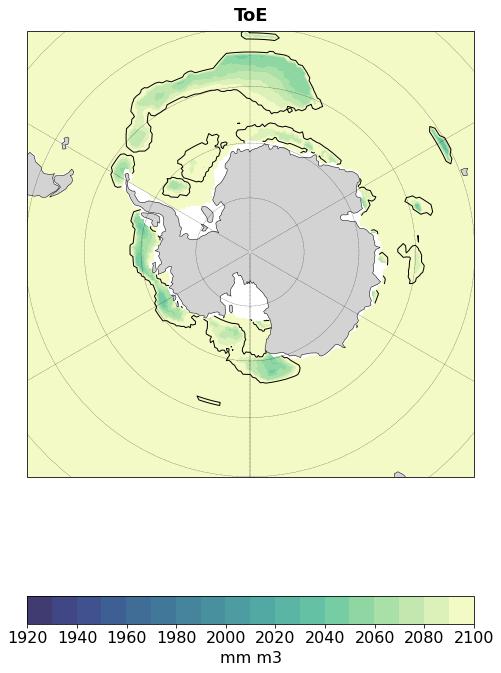

In [51]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
unit = 'mm m3'
vp4 = 'toe_KGP'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(2,1, height_ratios=[2,0.1])
t4 = 'ToE'
################### FAR RIGHT MOST PLOT ############################
ax = fig.add_subplot(gs[0, :], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = toe_plot(dsp[vp4])
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,:]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

ax = fig.get_axes()
#gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)


## Press Plot:

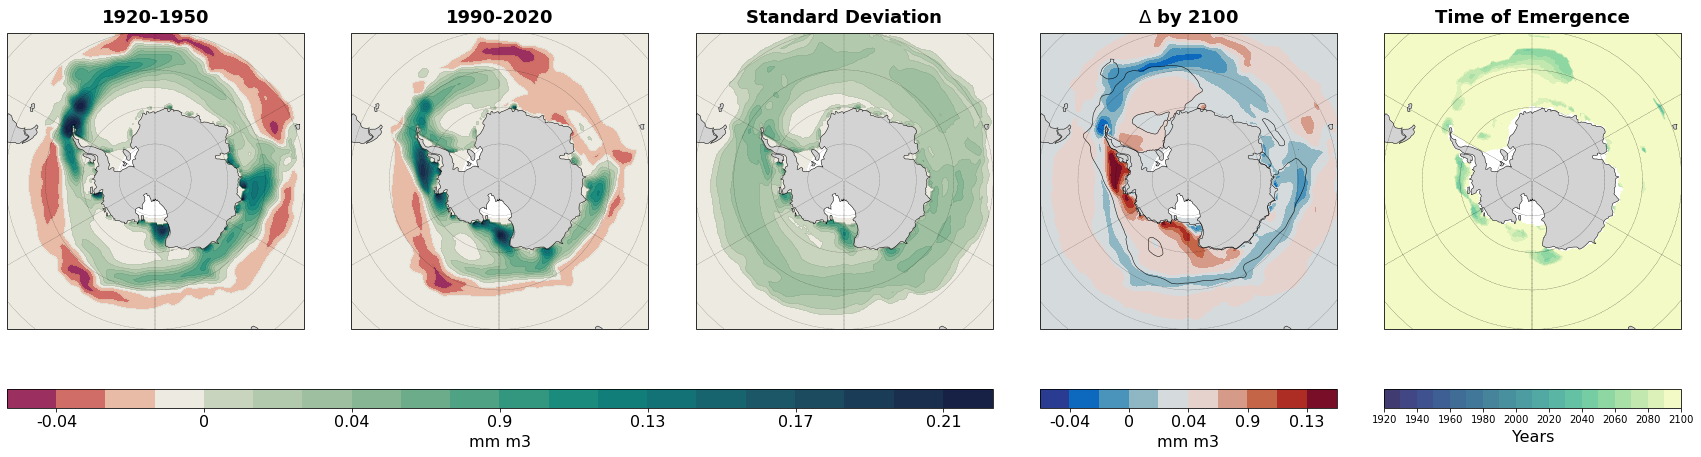

In [199]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
pt = 'KGP-MEAN_STD_DELTA_TOE'

vp1 = 'dso_KGP_mean'
vp2 = 'dsm_KGP_mean'
vp3 = 'dssa_KGP_std'
unit = 'mm m3'

vp4 = 'KGP_mean_delta'
vc = 'dsm_KGP_mean'

vp5 = 'toe_KGP'
unit2 = 'Years'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2,5, height_ratios=[2,0.1])
t1, t2, t3, t4, t5 = '1920-1950', '1990-2020', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
################### COLORBAR FOR LEFT 3 PLOTS ############################
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### 2nd RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], dsp[vc], lines=False)
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)


################### FAR RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 4], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = toe_plot(dsp[vp5])
ax.set_title(f'{t5}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,4]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=10)



ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

# Repeat for SST

In [200]:
v = 'SST'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        'KGP_mean': dsm['KGP'],
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        f'toe_{v}': dst[v],        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:         (nlat: 93, nlon: 321)
Coordinates:
    length          float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG           (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    KGP_mean        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dso_SST_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_SST_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SST_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    toe_SST         (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>
    dssa_SST_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [201]:
 print(dsp.dso_SST_mean.mean());

# print(dsp.dssa_SST_std.min());
# print(dsp.dssa_SST_std.max());

<xarray.DataArray 'dso_SST_mean' ()>
array(6.86697233)
Coordinates:
    length   float64 40.0


## Set Levels etc 

In [233]:
np.arange(-1.5,5.25,.25)

array([-1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,
        0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,
        3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ])

In [226]:
# Control, Future, STDEV 
levels = np.arange(-1.5,5.25,.25)#np.linspace(-1.5, 10, 23)

# SST Change 
level_p = [0, 0.219]
levels_chng = np.arange(-6,6,.5)
labels_diff = []
levels_cont = [-1, 5]

#Colors
cmap = cmocean.cm.thermal
cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='min', N=None)

#Standard
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [227]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [228]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels,
                     extend = 'both',
                     #norm=MidpointNormalize( midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='gray',
                    levels=levels_cont,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [229]:
def change_plot(da, dc, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k', 
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


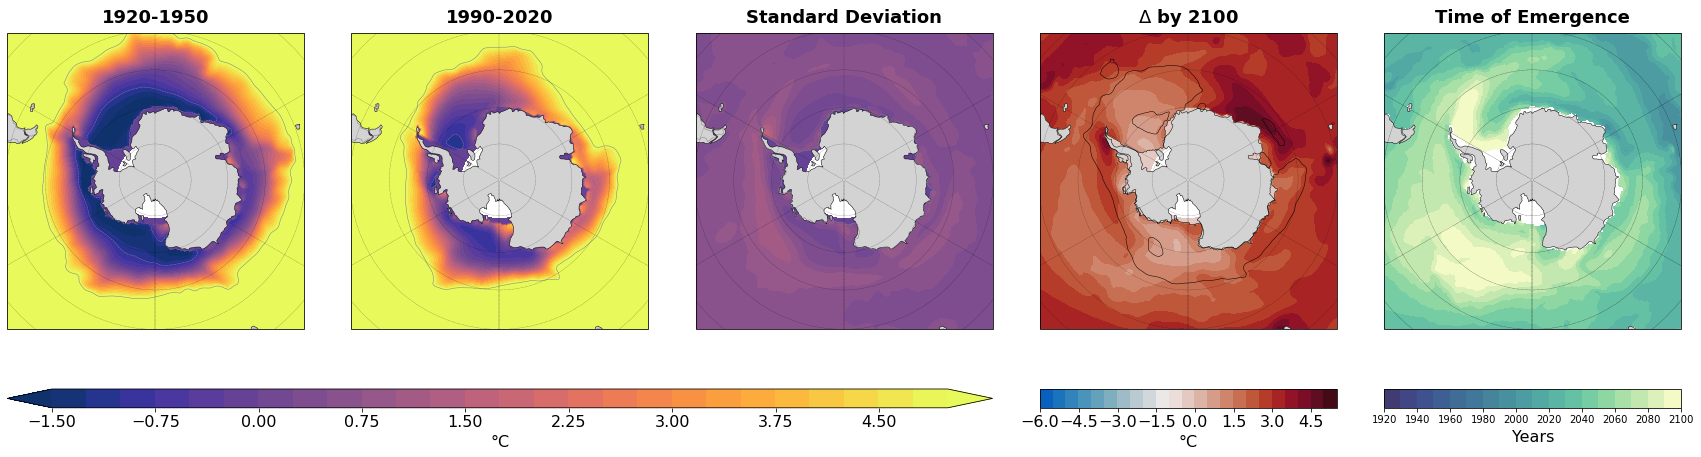

In [230]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
pt = 'SST-MEAN_STD_DELTA'

vp1 = 'dso_SST_mean'
vp2 = 'dsm_SST_mean'
vp3 = 'dssa_SST_std'
unit = '°C'

vp4 = 'SST_mean_delta'
vc = 'KGP_mean'

vp5 = 'toe_SST'
unit2 = 'Years'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2,5, height_ratios=[2,0.1])
t1, t2, t3, t4, t5 = '1920-1950', '1990-2020', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
################### COLORBAR FOR LEFT 3 PLOTS ############################
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### 2nd RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], dsp[vc], lines=False)
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)


################### FAR RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 4], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = toe_plot(dsp[vp5])
ax.set_title(f'{t5}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,4]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=10)

ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

___
# Repeat for Chl

In [234]:
v = 'Chl_surf'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean
dst = ds_toe

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        'KGP_mean': dsm['KGP'],
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_delta': dsm[v]-dso[v],
        f'toe_{v}': dst[v],        
        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:              (nlat: 93, nlon: 321)
Coordinates:
    length               float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                 (nlat, nlon) float64 -79.22 -79.22 ... -30.08 -30.08
    TLONG                (nlat, nlon) float64 -220.6 -219.4 ... 138.3 139.4
    KGP_mean             (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dso_Chl_surf_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dsm_Chl_surf_mean    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Chl_surf_mean_delta  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    toe_Chl_surf         (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>
    dssa_Chl_surf_std    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [235]:
print(dsp.dso_Chl_surf_mean.mean());

print(dsp.dssa_Chl_surf_std.min());
print(dsp.dssa_Chl_surf_std.max());

<xarray.DataArray 'dso_Chl_surf_mean' ()>
array(0.51278091)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'dssa_Chl_surf_std' ()>
array(0.)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'dssa_Chl_surf_std' ()>
array(3.2459988)
Coordinates:
    length   float64 40.0


### Set up levels

In [50]:
print(dsp.Chl_surf_mean_delta.min())
print(dsp.Chl_surf_mean_delta.max())
print(dsp.Chl_surf_mean_delta.mean())

<xarray.DataArray 'Chl_surf_mean_delta' ()>
array(-4.06240065)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'Chl_surf_mean_delta' ()>
array(1.58842662)
Coordinates:
    length   float64 40.0
<xarray.DataArray 'Chl_surf_mean_delta' ()>
array(-0.07143004)
Coordinates:
    length   float64 40.0


In [51]:
#np.arange(-1.8,1.8,.2)
np.linspace(-1.8,1.8,13)

array([-1.80000000e+00, -1.50000000e+00, -1.20000000e+00, -9.00000000e-01,
       -6.00000000e-01, -3.00000000e-01, -2.22044605e-16,  3.00000000e-01,
        6.00000000e-01,  9.00000000e-01,  1.20000000e+00,  1.50000000e+00,
        1.80000000e+00])

In [244]:
# Control, Future, STDEV 
levels = np.logspace(-2.3,.815,11)
norm = colors.LogNorm(vmin=levels[0], vmax=levels[-1])
labels = [0.005, 0.021, 0.088, 0.37, 1.6, 6.5]

# Change 
level_p = [0, 0.219]
levels_chng =np.linspace(-1.8,1.8,13)#np.arange(-1.8,1.8,.2) #[-3.4, -2.6, -1.8, -0.9, -0.08, 0.8, 1.6]
levels_cont = [0, 0.5]

#Colors
cmap = cmocean.cm.dense
#cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

### Run Plotting Functions

In [245]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, #extend = 'both',
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='gray',
                    levels=levels_cont,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [246]:
def change_plot(da, dc, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k',
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


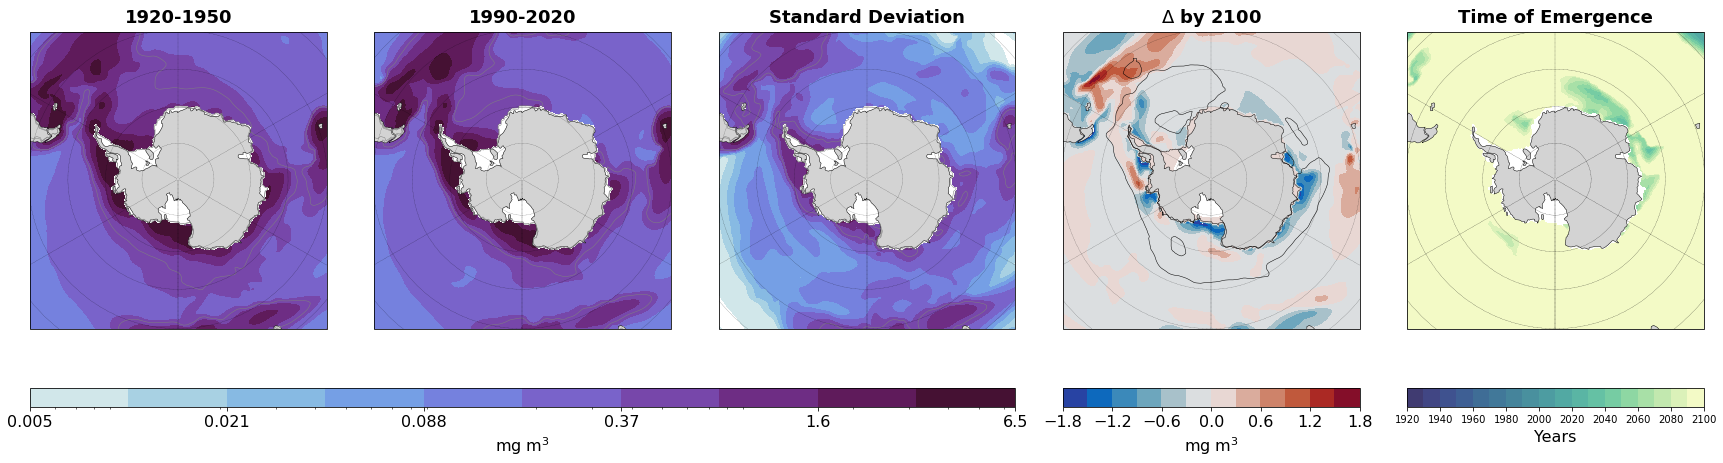

In [247]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
pt = 'CHL-MEAN_STD_DELTA'

vp1 = 'dso_Chl_surf_mean'
vp2 = 'dsm_Chl_surf_mean'
vp3 = 'dssa_Chl_surf_std'
unit = 'mg m$^3$'

vp4 = 'Chl_surf_mean_delta'
vc = 'KGP_mean'

vp5 = 'toe_Chl_surf'
unit2 = 'Years'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2,5, height_ratios=[2,0.1])
t1, t2, t3, t4, t5 = '1920-1950', '1990-2020', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
################### COLORBAR FOR LEFT 3 PLOTS ############################
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### 2nd RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], dsp[vc], lines=False)
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)


################### FAR RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 4], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = toe_plot(dsp[vp5])
ax.set_title(f'{t5}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,4]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=10)

ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')